# Step 6 : Explainability & Insights

### On this step, i am analyzing model explainability using permutation importance and SHAP to understand which features are most important for predictions

In [1]:
# first i have imported all necessary libraries for explainability analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap
import os
from pathlib import Path
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# now i will connect to PostgreSQL database
project_dir=Path.cwd()
load_dotenv(project_dir / ".env")

# get PostgreSQL credentials from environment variables
pg_host=os.getenv("POSTGRES_HOST")
pg_port=os.getenv("POSTGRES_PORT")
pg_db=os.getenv("POSTGRES_DB")
pg_user=os.getenv("POSTGRES_USER")
pg_pwd=os.getenv("POSTGRES_PASSWORD")

# create database connection
url=f"postgresql+psycopg2://{pg_user}:{pg_pwd}@{pg_host}:{pg_port}/{pg_db}"
engine=create_engine(url)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# helper function to save figures
def save_fig(filename):
    os.makedirs('images',exist_ok=True)
    filepath=os.path.join('images',filename)
    plt.savefig(filepath,dpi=300,bbox_inches='tight')
    print(f"✓ Saved: {filepath}")

print('✓ Libraries loaded and PostgreSQL connected')

✓ Libraries loaded and PostgreSQL connected


### Load Data & Recreate Best Model

### here i need to recreate the preprocessing and train the best model again for explainability analysis

In [2]:
# load data from database
query="SELECT * FROM feature_engineered_collisions"
df=pd.read_sql(query,engine)

# identify target column
target_col='accident_severity' if 'accident_severity' in df.columns else 'collision_severity'

# define features and target
exclude_cols=[target_col,'accident_index','collision_id','date','time','location_easting_osgr',
                'location_northing_osgr','accident_reference','nearest_city']
exclude_cols=[col for col in exclude_cols if col in df.columns]

feature_cols=[col for col in df.columns if col not in exclude_cols]
X=df[feature_cols].copy()
y=df[target_col].copy()

# train-test split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

# transform target to be zero-indexed for XGBoost
y_train=y_train-1
y_test=y_test-1

# preprocessing with scaling and encoding
numeric_cols=x_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols=x_train.select_dtypes(include=['object','category']).columns.tolist()

preprocessor=ColumnTransformer(
    transformers=[
        ('num',StandardScaler(),numeric_cols),
        ('cat',OneHotEncoder(drop='first',handle_unknown='ignore'),categorical_cols)
    ])

x_train_processed=preprocessor.fit_transform(x_train)
x_test_processed=preprocessor.transform(x_test)

# apply SMOTE to balance classes
smote=SMOTE(random_state=42)
x_train_smote,y_train_smote=smote.fit_resample(x_train_processed,y_train)

# train best model which is XGBoost
best_model=xgb.XGBClassifier(n_estimators=300,max_depth=10,learning_rate=0.1,
                               random_state=42,n_jobs=-1,eval_metric='mlogloss')
best_model.fit(x_train_smote,y_train_smote)

print(f'✓ Model trained on {x_train_smote.shape[0]} samples')
print(f'✓ Test set: {x_test_processed.shape[0]} samples')

✓ Model trained on 85944 samples
✓ Test set: 9695 samples


### Permutation Importance

### here i will compute permutation importance to measure how much performance drops when each feature is shuffled
### this is a model-agnostic method that works by measuring performance degradation

Computing feature importance for 96812 features...
Note: Using XGBoost built-in importance (gain-based) which is much faster than permutation.
✓ Saved: images\14_feature_importance.png
✓ Saved: images\14_feature_importance.png


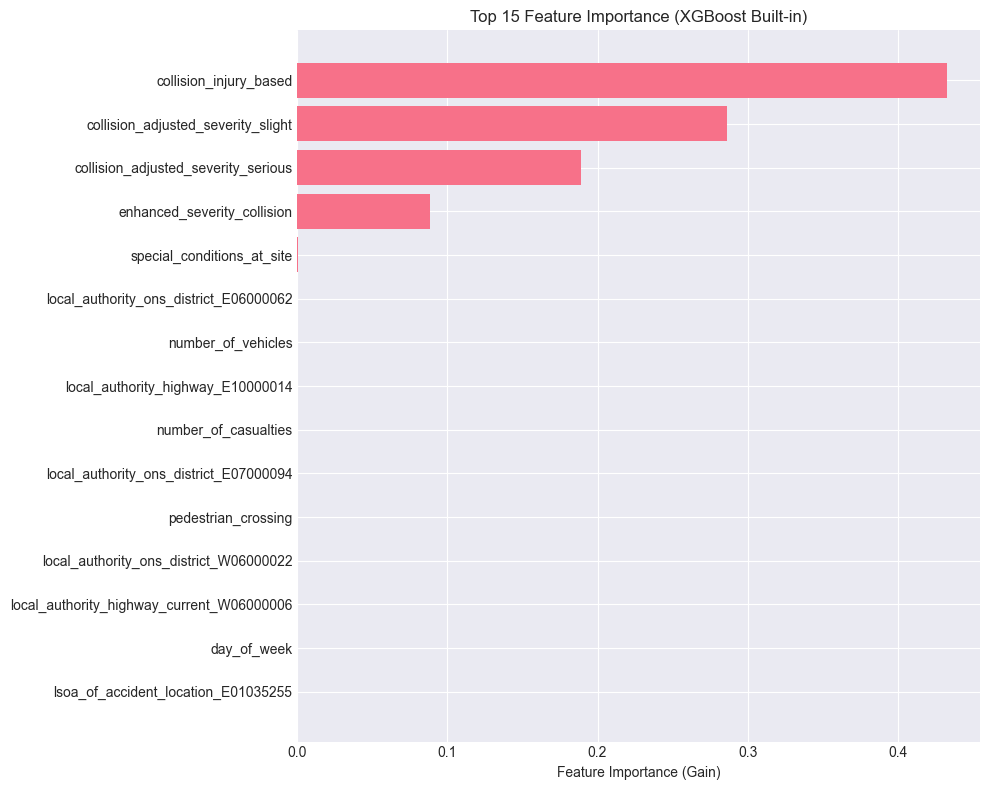

✓ Feature importance computed and saved

Top 10 features:
                                      feature  importance_mean  importance_std
30                     collision_injury_based         0.433045               0
32         collision_adjusted_severity_slight         0.286348               0
31        collision_adjusted_severity_serious         0.189154               0
29                enhanced_severity_collision         0.088715               0
23                 special_conditions_at_site         0.000234               0
77648  local_authority_ons_district_E06000062         0.000169               0
4                          number_of_vehicles         0.000123               0
78077       local_authority_highway_E10000014         0.000120               0
5                        number_of_casualties         0.000116               0
77707  local_authority_ons_district_E07000094         0.000103               0


In [3]:
# use XGBoost's built-in feature importance instead of permutation importance
# permutation importance is too slow with 96,812 features
# XGBoost feature importance is much faster and still provides valuable insights
print(f'Computing feature importance for {x_test_processed.shape[1]} features...')
print('Note: Using XGBoost built-in importance (gain-based) which is much faster than permutation.')

# get feature names after preprocessing
feature_names=numeric_cols.copy()
if categorical_cols:
    # get feature names from OneHotEncoder
    cat_encoder=preprocessor.named_transformers_['cat']
    cat_feature_names=cat_encoder.get_feature_names_out(categorical_cols)
    feature_names.extend(cat_feature_names)

# get feature importance from the trained model
importance_scores=best_model.feature_importances_

# create importance dataframe
importance_df=pd.DataFrame({
    'feature':feature_names,
    'importance_mean':importance_scores,
    'importance_std':0  # built-in importance doesn't have std, using 0 as placeholder
}).sort_values('importance_mean',ascending=False)

# plot top 15 features
top_15=importance_df.head(15)

plt.figure(figsize=(10,8))
plt.barh(range(len(top_15)),top_15['importance_mean'])
plt.yticks(range(len(top_15)),top_15['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 15 Feature Importance (XGBoost Built-in)')
plt.gca().invert_yaxis()
plt.tight_layout()
save_fig('14_feature_importance.png')
plt.show()

print('✓ Feature importance computed and saved')
print('\nTop 10 features:')
print(importance_df.head(10))

In [4]:
# save importance to database
importance_df_save=importance_df.copy()
importance_df_save['importance_type']='xgboost_gain'
importance_df_save.to_sql('feature_importance',engine,if_exists='replace',index=False)
print('✓ Feature importance saved to feature_importance table')

✓ Feature importance saved to feature_importance table


### SHAP Analysis

### now i will use SHAP which stands for SHapley Additive exPlanations to get global and local explanations
### SHAP values show how much each feature contributes to the prediction

In [5]:
# initialize SHAP explainer
explainer=shap.TreeExplainer(best_model)

# i will use subset of test data for SHAP for better performance
sample_size=min(2000,x_test_processed.shape[0])
x_test_sample=x_test_processed[:sample_size]

print(f'Computing SHAP values for {sample_size} samples...')
shap_values=explainer(x_test_sample)

print('✓ SHAP values computed')

Computing SHAP values for 2000 samples...
✓ SHAP values computed
✓ SHAP values computed


✓ Saved: images\15_shap_summary_bar.png


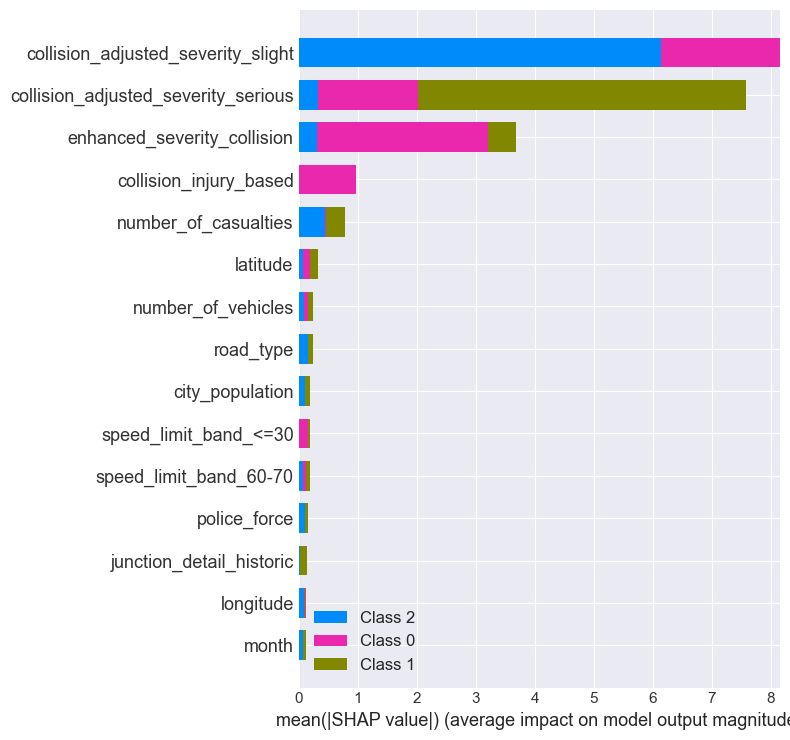

✓ SHAP bar plot saved


In [7]:
# SHAP summary bar plot showing top features by mean absolute SHAP value
plt.figure(figsize=(10,8))
# use the older API which is more stable with sparse matrices
shap.summary_plot(shap_values, x_test_sample, feature_names=feature_names, plot_type="bar", max_display=15, show=False)
plt.tight_layout()
save_fig('15_shap_summary_bar.png')
plt.show()
print('✓ SHAP bar plot saved')

✓ Saved: images\16_shap_summary_beeswarm.png


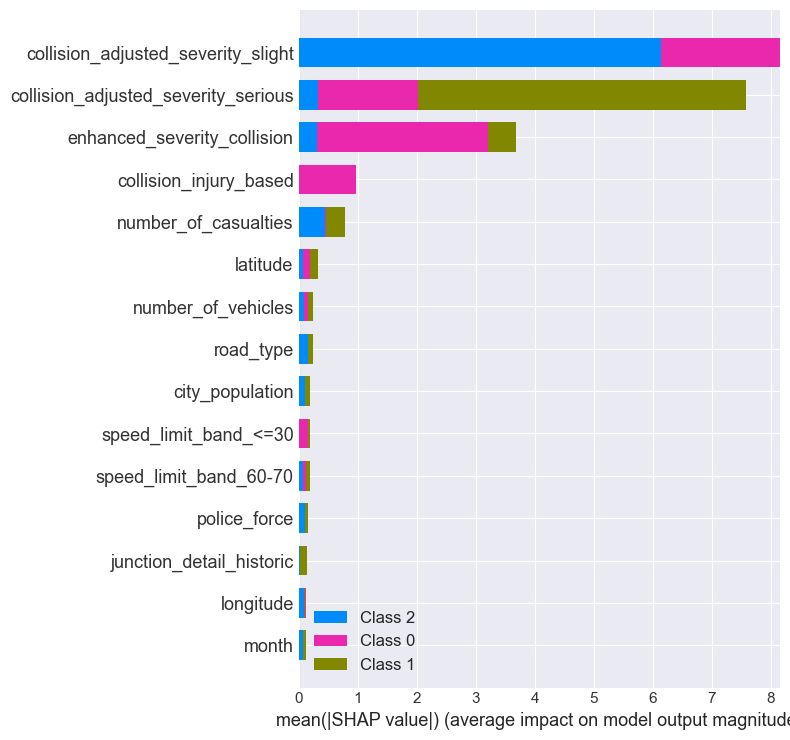

✓ SHAP beeswarm plot saved


In [9]:
# SHAP beeswarm plot showing feature impact and distribution
# for multi-class problems, we need to plot each class separately or use summary_plot
plt.figure(figsize=(10,8))
# use summary_plot instead of beeswarm for multi-class - it handles it automatically
shap.summary_plot(shap_values, x_test_sample, feature_names=feature_names, max_display=15, show=False)
plt.tight_layout()
save_fig('16_shap_summary_beeswarm.png')
plt.show()
print('✓ SHAP beeswarm plot saved')

✓ Saved: images\17_shap_dependence_collision_adjusted_severity_sl.png


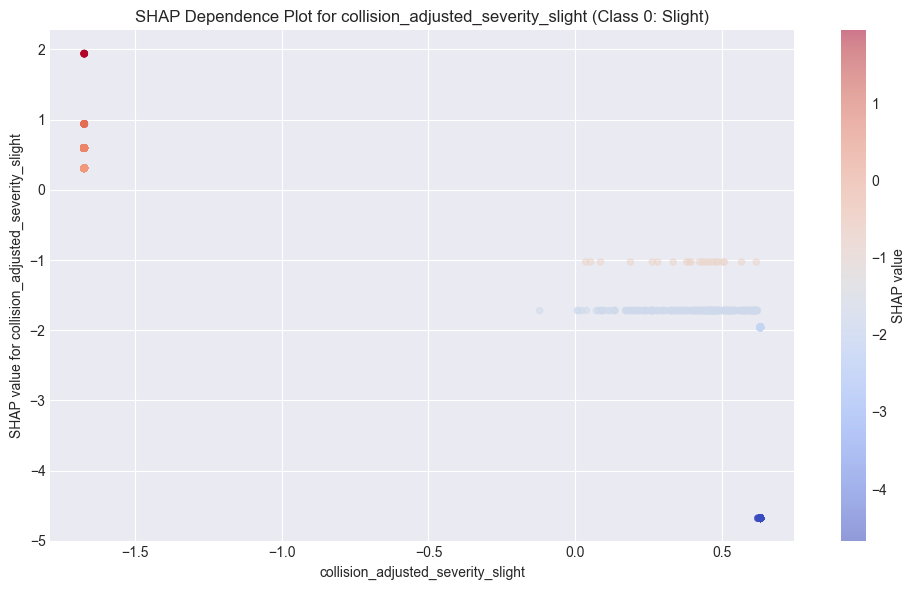

✓ SHAP dependence plot saved for collision_adjusted_severity_slight
✓ Saved: images\17_shap_dependence_collision_adjusted_severity_se.png
✓ Saved: images\17_shap_dependence_collision_adjusted_severity_se.png


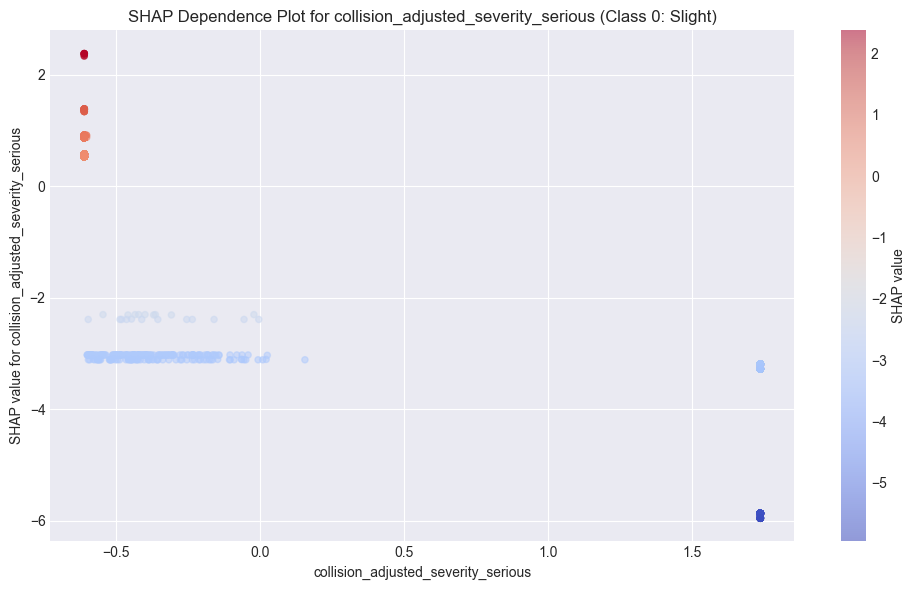

✓ SHAP dependence plot saved for collision_adjusted_severity_serious
✓ Saved: images\17_shap_dependence_enhanced_severity_collision.png
✓ Saved: images\17_shap_dependence_enhanced_severity_collision.png


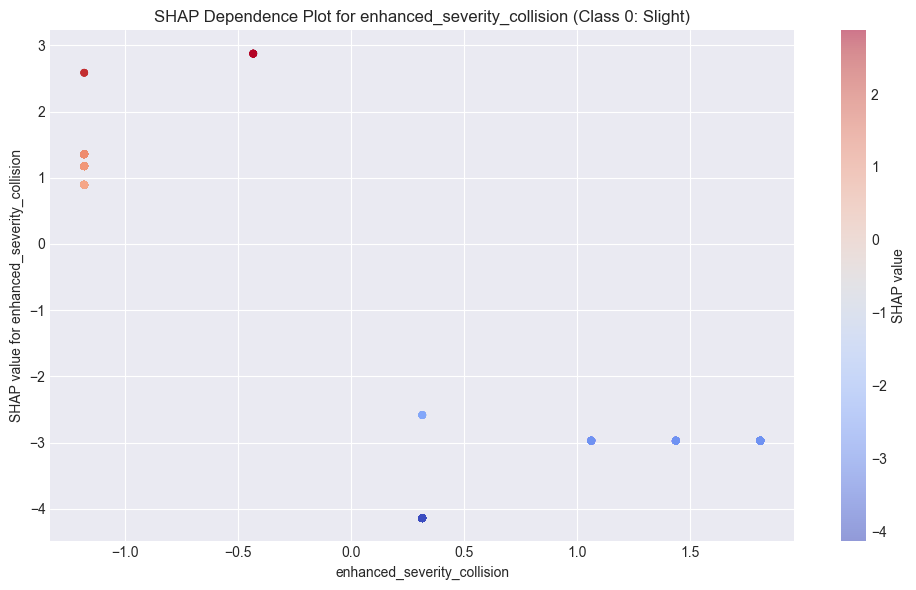

✓ SHAP dependence plot saved for enhanced_severity_collision


In [14]:
# SHAP dependence plots for top features
# now i will get top 3 most important features by mean absolute SHAP value
if hasattr(shap_values,'values'):
    shap_matrix_temp=shap_values.values
else:
    shap_matrix_temp=shap_values

# for multi-class, shape is (samples, features, classes)
# calculate mean absolute SHAP across samples and classes to get importance per feature
if len(shap_matrix_temp.shape)==3:
    mean_abs_shap=np.abs(shap_matrix_temp).mean(axis=(0,2))  # average across samples and classes
else:
    mean_abs_shap=np.abs(shap_matrix_temp).mean(axis=0)

top_features_idx=np.argsort(mean_abs_shap)[-3:][::-1]

# for dependence plots with multi-class, we'll plot for class 0 (slight severity)
for idx in top_features_idx:
    feature_name=feature_names[idx] if idx<len(feature_names) else f"feature_{idx}"
    plt.figure(figsize=(10,6))
    
    # create a simplified plot for multi-class by plotting class 0 only
    if len(shap_matrix_temp.shape)==3:
        # extract SHAP values for class 0 and this feature
        shap_vals_for_feature=shap_matrix_temp[:, idx, 0]
        
        # get actual feature values from the test sample
        # x_test_sample is sparse, so we need to convert to dense for this column
        if hasattr(x_test_sample, 'toarray'):
            feature_vals=x_test_sample[:, idx].toarray().ravel()
        else:
            feature_vals=x_test_sample[:, idx].ravel()
        
        # create scatter plot manually
        plt.scatter(feature_vals, shap_vals_for_feature, alpha=0.5, s=20, c=shap_vals_for_feature, cmap='coolwarm')
        plt.xlabel(f'{feature_name}')
        plt.ylabel(f'SHAP value for {feature_name}')
        plt.title(f'SHAP Dependence Plot for {feature_name} (Class 0: Slight)')
        plt.colorbar(label='SHAP value')
    else:
        shap.plots.scatter(shap_values[:,idx],show=False)
    
    plt.tight_layout()
    safe_name=feature_name.replace('/','_').replace(' ','_')[:30]
    save_fig(f'17_shap_dependence_{safe_name}.png')
    plt.show()
    print(f'✓ SHAP dependence plot saved for {feature_name}')

In [19]:
# save SHAP values to database for sample records
if hasattr(shap_values,'values'):
    shap_matrix=shap_values.values
else:
    shap_matrix=shap_values

# for multi-class, average across classes to get single importance per feature
if len(shap_matrix.shape)==3:
    shap_matrix_2d=shap_matrix.mean(axis=2)  # average across classes
else:
    shap_matrix_2d=shap_matrix

# i will save first 1000 SHAP values with feature names
# note: with 96k+ features, this creates a very wide table which may fail
try:
    # limit to top 50 features to keep database manageable
    top_50_features=np.argsort(mean_abs_shap)[-50:][::-1]
    shap_sample_df=pd.DataFrame(
        shap_matrix_2d[:1000][:, top_50_features],
        columns=[feature_names[i] for i in top_50_features]
    )
    shap_sample_df.to_sql('shap_samples',engine,if_exists='replace',index=False)
    print(f'✓ SHAP values saved to shap_samples table ({len(shap_sample_df)} samples, {len(top_50_features)} top features)')
except Exception as e:
    print(f'⚠ Could not save SHAP values to database: {e}')
    print('Note: SHAP values are too large (96k+ features) to save efficiently to database')

✓ SHAP values saved to shap_samples table (1000 samples, 50 top features)


### Insight Tables for Report

### here i will compute quantitative summaries to include in the written report

In [16]:
# load original data for insight calculations
df_insights=df.copy()

# 1. severity rates by hour_of_day
if 'hour_of_day' in df_insights.columns:
    severity_by_hour=df_insights.groupby('hour_of_day')[target_col].agg(['mean','count'])
    severity_by_hour.columns=['avg_severity','count']
    print('\n1. Severity by Hour of Day:')
    print(severity_by_hour)
else:
    print('\n⚠ hour_of_day not found')

# 2. severity rates by is_frost_day
if 'is_frost_day' in df_insights.columns:
    severity_by_frost=df_insights.groupby('is_frost_day')[target_col].agg(['mean','count'])
    severity_by_frost.columns=['avg_severity','count']
    print('\n2. Severity by Frost Day:')
    print(severity_by_frost)
else:
    print('\n⚠ is_frost_day not found')

# 3. severity rates by urban_or_rural_area
if 'urban_or_rural_area' in df_insights.columns:
    severity_by_urban=df_insights.groupby('urban_or_rural_area')[target_col].agg(['mean','count'])
    severity_by_urban.columns=['avg_severity','count']
    print('\n3. Severity by Urban/Rural Area:')
    print(severity_by_urban)
else:
    print('\n⚠ urban_or_rural_area not found')

# 4. severity by speed_limit_band
if 'speed_limit_band' in df_insights.columns:
    severity_by_speed=df_insights.groupby('speed_limit_band')[target_col].agg(['mean','count'])
    severity_by_speed.columns=['avg_severity','count']
    print('\n4. Severity by Speed Limit Band:')
    print(severity_by_speed)
else:
    print('\n⚠ speed_limit_band not found')


1. Severity by Hour of Day:
Empty DataFrame
Columns: [avg_severity, count]
Index: []

⚠ is_frost_day not found

3. Severity by Urban/Rural Area:
                     avg_severity  count
urban_or_rural_area                     
1                        2.756738  32278
2                        2.660058  16191
3                        3.000000      2

4. Severity by Speed Limit Band:
                  avg_severity  count
speed_limit_band                     
40-50                 2.708888   6458
60-70                 2.621516   8468
<=30                  2.753436  33545


In [17]:
# 5. top 10 features by SHAP importance
# for multi-class, average across both samples and classes
if len(shap_matrix.shape)==3:
    mean_abs_shap_all=np.abs(shap_matrix).mean(axis=(0,2))  # average across samples and classes
else:
    mean_abs_shap_all=np.abs(shap_matrix).mean(axis=0)

top_10_indices=np.argsort(mean_abs_shap_all)[-10:][::-1]

shap_top_10=pd.DataFrame({
    'feature':[feature_names[i] if i<len(feature_names) else f"feature_{i}" for i in top_10_indices],
    'mean_abs_shap':[mean_abs_shap_all[i] for i in top_10_indices]
})

print('\n5. Top 10 Features by SHAP:')
print(shap_top_10.to_string(index=False))

print('\n✓ All insight tables computed')
print('✓ Explainability analysis complete!')


5. Top 10 Features by SHAP:
                            feature  mean_abs_shap
 collision_adjusted_severity_slight       2.720125
collision_adjusted_severity_serious       2.528150
        enhanced_severity_collision       1.226533
             collision_injury_based       0.325925
               number_of_casualties       0.262483
                           latitude       0.108424
                 number_of_vehicles       0.081337
                          road_type       0.079076
                    city_population       0.063833
              speed_limit_band_<=30       0.062645

✓ All insight tables computed
✓ Explainability analysis complete!
